In [6]:
import pandas as pd

import os
from sklearn.preprocessing import MinMaxScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings('ignore')

csv_list=[]
file =os.listdir()
for i in file:
    if ( i[-3:]=='csv'):
        csv_list.append(i)

In [7]:
def make_fa_score(csv_list):
    #파일을 하나씩 읽어오면서 진행
    for i in csv_list:
        print('###'+i+'파일실행')
        df = pd.read_csv(i,encoding='euc-kr')
        df_col=df[['상권코드','price_'+i[7:13]+'_max','strc_'+i[7:13]+'_max','pop_'+i[7:13]+'_max','상가수','area','유동인구 평균','매출금액 평균','폐업수']]

        #스케일링
        scaler = MinMaxScaler()
        df_minmax_scaled = scaler.fit_transform(df_col.iloc[:,1:-1])
        df_minmax_scaled = pd.DataFrame(df_minmax_scaled,columns=df_col.iloc[:,1:-1].columns)
        #폐업수 cost 스케일링
        cob = (df_col[['폐업수']].max()-df_col[['폐업수']]) / ( df_col[['폐업수']].max()-df_col[['폐업수']].min() )

        #요인분석 데이터셋 생성
        data_set = pd.concat([df_minmax_scaled,cob],axis=1)
        
        #kmo 테스트
        kmo_all,kmo_model=calculate_kmo(data_set)

        print('kmo test value:' ,kmo_model)
        #요인분석
        data_set.pop('area')
        fa = FactorAnalyzer(n_factors=7,rotation=None)
        fa.fit(data_set)

        ev,v=fa.get_eigenvalues()
        print('eignvalue 값:',ev)
        
        fa=FactorAnalyzer(n_factors=2,rotation='varimax')
        fa.fit(data_set)
        fa.get_factor_variance()
        
        #가중치 제작
        pd.DataFrame(fa.loadings_,columns=['fa1','fa2'])

        data_fa = pd.DataFrame(fa.loadings_,columns=['fa1','fa2'],index=data_set.columns)
        data_fa = data_fa.apply(lambda x:x*x)
        data_fa['sum'] = data_fa.sum(axis=1)
        data_fa['가중치'] = data_fa['sum']/data_fa['sum'].sum()
        
        data_fa.to_csv('상권_가중치/'+i[7:13]+'_가중치.csv',encoding='euc-kr')
        #스코어 제작
        data_score = pd.DataFrame()
        
        for j in range(len(data_fa)):
            data_score=pd.concat([data_score,(data_set.iloc[:,j] * data_fa.iloc[j,3])],axis=1)
        data_score[i[9:13]+'_score']=data_score.sum(axis=1)
        
        #점수와 위치정보 결합
        a = df[df.columns[:7]]
        a = pd.concat([a,data_score],axis=1)
        
        #등급 산출
        bins=[]
        for k in reversed(range(1,11)):
            #등급이라는 접미사를 붙이고 떼고
            #bins.append(str(k)+'등급')
            bins.append(k)
        a[i[9:13]+'_절대등급'] = pd.cut(a[i[9:13]+'_score'],10,labels=bins)
        a[i[9:13]+'_상대등급'] = pd.qcut(a[i[9:13]+'_score'],10,labels=bins)
        
        #저장
        a.to_csv('상권_요인분석/FA_'+i,encoding='euc-kr',index=False)

In [8]:
make_fa_score(csv_list)

###market_201712_pre.csv파일실행
kmo test value: 0.808905341056021
eignvalue 값: [4.20775477 1.3927058  0.47127092 0.37432015 0.26698582 0.18799906
 0.09896347]
###market_201806_pre.csv파일실행
kmo test value: 0.8081608105532341
eignvalue 값: [4.21195264 1.38840581 0.47058177 0.37557237 0.26331448 0.19165003
 0.09852291]
###market_201812_pre.csv파일실행
kmo test value: 0.8153702817526287
eignvalue 값: [4.2203991  1.41672613 0.45961656 0.34708324 0.27007043 0.19083377
 0.09527077]
###market_201906_pre.csv파일실행
kmo test value: 0.8191234199085127
eignvalue 값: [4.14839285 1.45843733 0.4537704  0.33970876 0.30361736 0.20290868
 0.09316462]
###market_201912_pre.csv파일실행
kmo test value: 0.8121794254202479
eignvalue 값: [4.05921307 1.41586901 0.47388335 0.38669332 0.34044156 0.20943458
 0.11446512]
###market_202006_pre.csv파일실행
kmo test value: 0.8015409031345728
eignvalue 값: [4.00244907 1.37941413 0.500138   0.42593495 0.3608264  0.22261302
 0.10862443]
###market_202012_pre.csv파일실행
kmo test value: 0.784858044385

KeyError: "['price_)_sum__max', 'strc_)_sum__max', 'pop_)_sum__max', '상가수', 'area', '유동인구 평균', '매출금액 평균', '폐업수'] not in index"

### 병합



In [18]:
fa_list = os.listdir('상권_요인분석/')

sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('상권_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:7]
for i in fa_list:
    df=pd.read_csv('상권_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3]]],axis=1)
    
sum_fa_list.to_csv('상권_요인분석/sum_fa_list.csv',encoding='euc-kr',index=False)

In [ ]:
#등급포함데이터 따로
sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('상권_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:7]
for i in fa_list:
    df=pd.read_csv('상권_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3:]]],axis=1)
    
sum_fa_list.to_csv('상권(등급포함)_sum_fa_list.csv',encoding='euc-kr',index=False)

# 한줄씩

In [7]:
csv_list=[]
file =os.listdir()
for i in file:
    if ( i[-3:]=='csv'):
        csv_list.append(i)

In [8]:
df = pd.read_csv('market_201712_pre.csv',encoding='euc-kr')

In [9]:
csv_list

['market_201712_pre.csv',
 'market_201806_pre.csv',
 'market_201812_pre.csv',
 'market_201906_pre.csv',
 'market_201912_pre.csv',
 'market_202006_pre.csv',
 'market_202012_pre.csv',
 'market_202106_pre.csv',
 'market_202112_pre.csv',
 'market_202206_pre.csv']

In [10]:
df

,상권명,다중지역정보,업종정보,위도,경도,wkt,상권코드,구분,price_201712_max,strc_201712_max,pop_201712_max,상가수,area,유동인구 평균,매출금액 평균,매출액_시점 개수,폐업수,폐업수_시점 개수
0,성남은행초등학교,"{""type"":""Polygon"",""coordinates"":[[[127.1687262...",두발 미용업/일반 교과학원/치킨 전문점/한식 일반 음식점업/노래 연습장 운영업/기타...,37.460705,127.168758,"POLYGON ((127.1687262760 37.4620601200, 127.16...",골목_1,골목상권,30659882.82,304.0,9494.0,144,74330.36627,546453.353333,2.496695e+09,6.0,10.0,6.0
1,가림로201번안길,"{""type"":""Polygon"",""coordinates"":[[[126.8617425...",전자상거래 소매업/기타 음ㆍ식료품 위주 종합 소매업/자동차 세차업/두발 미용업,37.475776,126.861436,"POLYGON ((126.8617425380 37.4748298650, 126.86...",골목_2,골목상권,20246090.90,428.0,7898.0,14,44415.19650,103885.485000,9.930088e+07,6.0,1.0,6.0
2,내각1로73번안길,"{""type"":""Polygon"",""coordinates"":[[[127.1649527...",한식 일반 음식점업/두발 미용업/부동산 중개 및 대리업/한식 육류 요리 전문점/노래...,37.711797,127.161510,"POLYGON ((127.1649527610 37.7043120880, 127.16...",골목_3,골목상권,13065354.89,312.0,4595.0,84,425896.39240,105892.018333,4.860243e+08,6.0,4.0,6.0
3,양주산성로,"{""type"":""Polygon"",""coordinates"":[[[126.9873577...",두발 미용업/일반 교과학원/화초 및 식물 소매업/통신기기 소매업/한식 육류 요리 전...,37.788623,126.987220,"POLYGON ((126.9873577160 37.7908375740, 126.98...",골목_4,골목상권,7974797.47,30.0,384.0,28,162099.07560,131725.688333,1.316368e+08,6.0,5.0,6.0
4,도일로135번길,"{""type"":""Polygon"",""coordinates"":[[[126.7835814...",두발 미용업/치킨 전문점/체인화 편의점/한식 일반 음식점업/기타 음ㆍ식료품 위주 종...,37.343110,126.783057,"POLYGON ((126.7835814060 37.3430218760, 126.78...",골목_5,골목상권,10866265.15,154.0,8596.0,31,41766.72043,102627.711667,2.952011e+08,6.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,광명사거리역_4번출구,"{""type"":""Polygon"",""coordinates"":[[[126.8536079...",기타 주점업/한식 일반 음식점업/한식 육류 요리 전문점/노래 연습장 운영업/커피 전...,37.479619,126.852135,"POLYGON ((126.8536079430 37.4782792810, 126.85...",발달_853,발달상권,28966019.23,277.0,7539.0,195,28388.93889,301012.606667,5.294551e+09,6.0,33.0,6.0
1673,성복2로,"{""type"":""Polygon"",""coordinates"":[[[127.0773354...",일반의원/두발 미용업/한식 일반 음식점업/의약품 및 의료용품 소매업/기타 주점업/셔...,37.313360,127.078773,"POLYGON ((127.0773354300 37.3137514240, 127.07...",발달_854,발달상권,13530577.24,19.0,1427.0,116,14307.02069,44489.735000,3.557348e+09,6.0,7.0,6.0
1674,광교중앙로,"{""type"":""Polygon"",""coordinates"":[[[127.0687753...",두발 미용업/일반 교과학원/피자 햄버거 샌드위치 및 유사 음식점업/한식 육류 요...,37.296904,127.068295,"POLYGON ((127.0687753130 37.2965215900, 127.06...",발달_855,발달상권,22635650.08,19.0,7092.0,127,36489.58697,397351.723333,4.158718e+09,6.0,17.0,6.0
1675,서수원버스터미널,"{""type"":""Polygon"",""coordinates"":[[[126.9719643...",기타 의복 소매업/화장품 비누 및 방향제 소매업/체인화 편의점/신발 소매업/속옷 ...,37.282524,126.970408,"POLYGON ((126.9719643130 37.2822193820, 126.97...",발달_856,발달상권,21272517.29,76.0,1944.0,67,41186.95950,185789.433333,1.309810e+10,6.0,2.0,6.0


In [11]:
df_col=df[['상권코드','price_'+csv_list[0][7:13]+'_max','strc_'+csv_list[0][7:13]+'_max','pop_'+csv_list[0][7:13]+'_max','상가수','유동인구 평균','매출금액 평균','폐업수']]

In [12]:
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/HANDotum.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_minmax_scaled = scaler.fit_transform(df_col.iloc[:,1:-1])

In [14]:
df_minmax_scaled = pd.DataFrame(df_minmax_scaled,columns=df_col.iloc[:,1:-1].columns)

In [15]:
#cob = close of business
cob = (df_col[['폐업수']].max()-df_col[['폐업수']]) / ( df_col[['폐업수']].max()-df_col[['폐업수']].min() )


In [16]:
data_set = pd.concat([df_minmax_scaled,cob],axis=1)

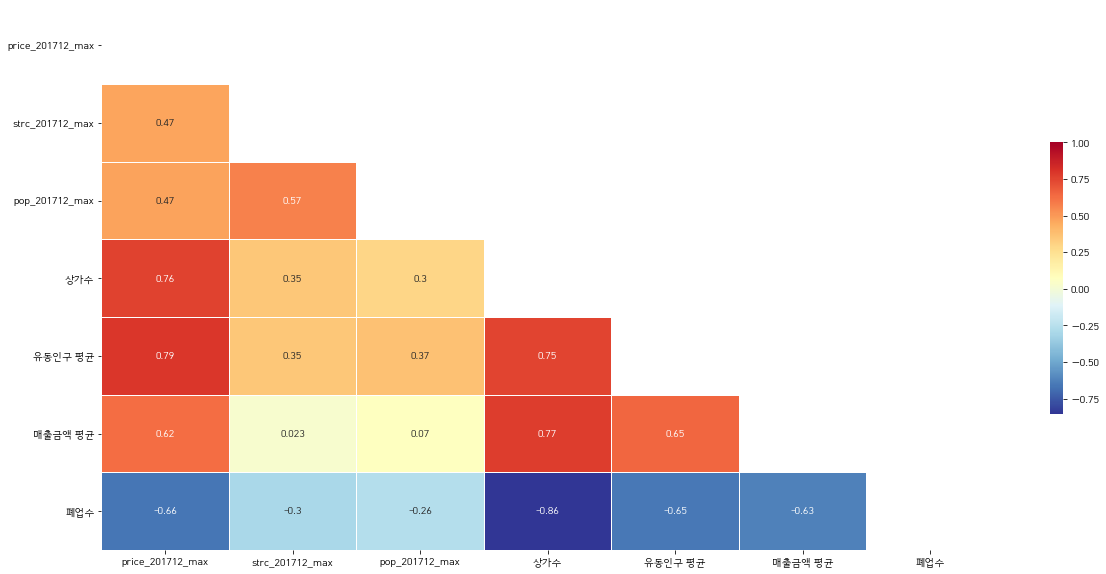

In [17]:
import numpy as np
import seaborn as sns
data_graph = data_set.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,10) )
# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data_graph, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 히트맵을 그린다
sns.heatmap(data_graph, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [18]:
data_set.head(2)

,price_201712_max,strc_201712_max,pop_201712_max,상가수,유동인구 평균,매출금액 평균,폐업수
0,0.164251,0.179245,0.308277,0.075630,0.150326,0.022164,0.925373
1,0.108462,0.252358,0.256454,0.007353,0.028348,0.000877,0.992537


### 요인분석

In [19]:
from factor_analyzer.factor_analyzer import FactorAnalyzer

In [22]:
# area 변수의 communality가 낮기 때문에 제거하고 분석해 볼 필요가 있음
# 분석 결과 더 좋은 퍼포먼스를 보이는 것으로 확인, area 변수 제거 고려 필요.

#data_set.pop('area')

In [23]:
fa = FactorAnalyzer(n_factors=7,rotation=None)
fa.fit(data_set)


ev,v=fa.get_eigenvalues()
ev
#기준 eigenvalue > 1

array([4.20775477, 1.3927058 , 0.47127092, 0.37432015, 0.26698582,
       0.18799906, 0.09896347])

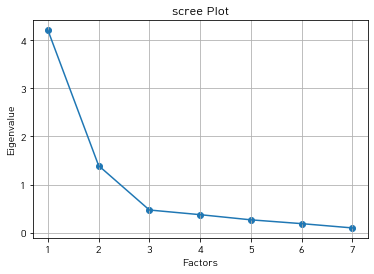

In [24]:
plt.scatter(range(1,data_set.shape[1]+1),ev)
plt.plot(range(1,data_set.shape[1]+1),ev)
plt.title('scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

#scree plot 상으로는 4개가 이상적으로 보이지만,  보조적인 수단이라는 점, 가중치 산출을 위한 요인분석이라는 점을 들어 2개 요인으로 축소
#요인분석을 개별적으로 추가 활용하기 위한 목적, (클러스터링 등) 이라면 4개 요인으로 늘려 보는 방향도 권장.

In [25]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(data_set)

kmo_model

#수치 매우 좋음

0.8188824008629242

In [26]:
from factor_analyzer import FactorAnalyzer
fa=FactorAnalyzer(n_factors=2,rotation='varimax')
fa.fit(data_set)
fa.get_factor_variance()


(array([3.3828154, 1.5964802]),
 array([0.48325934, 0.2280686 ]),
 array([0.48325934, 0.71132794]))

In [27]:
pd.DataFrame(fa.loadings_,columns=['fa1','fa2'])

,fa1,fa2
0,0.740463,0.491057
1,0.134083,0.770162
2,0.143797,0.717777
3,0.914825,0.249591
4,0.763551,0.351137
5,0.871978,-0.092554
6,-0.784611,-0.229849


In [28]:
data_fa = pd.DataFrame(fa.loadings_,columns=['fa1','fa2'],index=data_set.columns)

#communality와 eigenvalue 계산을 위한 컬럼 생성
data_fa = data_fa.apply(lambda x:x*x)
data_fa['sum'] = data_fa.sum(axis=1)
data_fa['가중치'] = data_fa['sum']/data_fa['sum'].sum()

In [29]:
data_fa

,fa1,fa2,sum,가중치
price_201712_max,0.548286,0.241137,0.789422,0.158541
strc_201712_max,0.017978,0.593149,0.611127,0.122734
pop_201712_max,0.020678,0.515204,0.535882,0.107622
상가수,0.836905,0.062296,0.899201,0.180588
유동인구 평균,0.583010,0.123297,0.706307,0.141849
매출금액 평균,0.760346,0.008566,0.768912,0.154422
폐업수,0.615614,0.052831,0.668444,0.134245


In [30]:
data_fa.loc[:,['가중치']]

,가중치
price_201712_max,0.158541
strc_201712_max,0.122734
pop_201712_max,0.107622
상가수,0.180588
유동인구 평균,0.141849
매출금액 평균,0.154422
폐업수,0.134245


In [31]:
data_score = pd.DataFrame()

In [32]:
for i in range(len(data_fa)):
    data_score=pd.concat([data_score,(data_set.iloc[:,i] * data_fa.iloc[i,3])],axis=1)

In [33]:
data_score['score']=data_score.sum(axis=1)

In [34]:
data_score['score'].rank(ascending=False)

0        210.0
1        396.0
2        660.0
3       1648.0
4        759.0
         ...  
1672     453.0
1673    1362.0
1674     621.0
1675     641.0
1676    1228.0
Name: score, Length: 1677, dtype: float64

In [35]:
a = df[df.columns[:7]]

In [36]:
a = pd.concat([a,data_score],axis=1)

In [37]:
bins=[]
for i in reversed(range(1,11)):
    bins.append(str(i)+'등급')

In [38]:
a['절대등급'] = pd.cut(a['score'],10,labels=bins)

In [39]:
a['상대등급'] = pd.qcut(a['score'],10,labels=bins)

In [40]:
a['절대등급'].value_counts()

10등급    1013
9등급      477
8등급      125
7등급       38
6등급       11
5등급        9
4등급        3
1등급        1
3등급        0
2등급        0
Name: 절대등급, dtype: int64

In [41]:
a['상대등급'].value_counts()

10등급    168
9등급     168
7등급     168
6등급     168
4등급     168
2등급     168
1등급     168
8등급     167
5등급     167
3등급     167
Name: 상대등급, dtype: int64

In [42]:
a[a['절대등급']=='2등급']

,상권명,다중지역정보,업종정보,위도,경도,wkt,상권코드,price_201712_max,strc_201712_max,pop_201712_max,상가수,유동인구 평균,매출금액 평균,폐업수,score,절대등급,상대등급


### 파일 병합

In [25]:
fa_list = os.listdir('상권_요인분석/')

In [26]:
sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('상권_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:7]
for i in fa_list:
    df=pd.read_csv('상권_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3:]]],axis=1)
    
sum_fa_list.to_csv('상권_요인분석/상권_sum_fa_list.csv',encoding='euc-kr',index=False)

In [23]:
pd.read_csv('상권_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,-3:]

,1712_score,1712_절대등급,1712_상대등급
0,0.243848,9,2
1,0.214496,9,3
2,0.192703,9,4
3,0.147467,10,10
4,0.187966,10,5
...,...,...,...
1672,0.209659,9,3
1673,0.162664,10,9
1674,0.195839,9,4
1675,0.194139,9,4
